In [2]:
%pylab inline --no-import-all
import seaborn as sns
import cv2

Populating the interactive namespace from numpy and matplotlib


In [103]:
img = cv2.cvtColor(cv2.imread("sym_detector/4.png"), cv2.COLOR_RGB2GRAY)

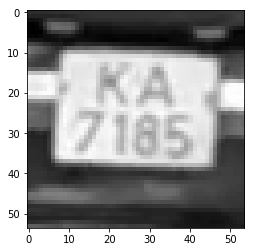

In [104]:
plt.imshow(img, cmap='gray')

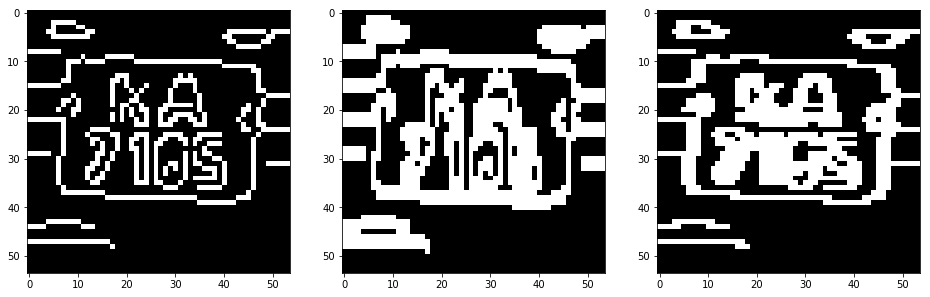

In [105]:
edges = cv2.Canny(img, 150, 200)
edgesHor = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3)))
edgesVer = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1)))

fig, ax =plt.subplots(1, 3, figsize=(16, 8)) 

ax[0].imshow(edges, cmap='gray')
ax[1].imshow(edgesHor, cmap='gray')
ax[2].imshow(edgesVer, cmap='gray')

In [106]:
height, width = edges.shape

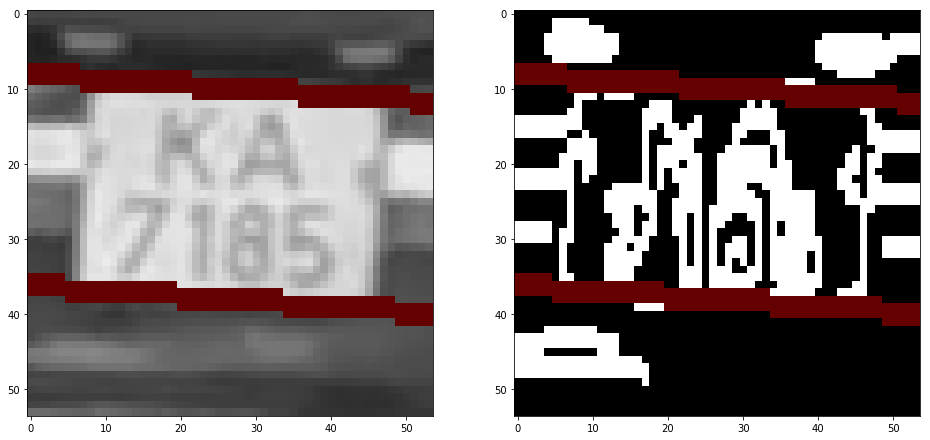

In [107]:
houghHor = cv2.HoughLines(edges, 1, np.pi/90, width//2)

img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
edges_copy = cv2.cvtColor(edgesHor, cv2.COLOR_GRAY2RGB)

for rho, theta in houghHor[:4, 0]:
    sin = np.sin(theta)
    cos = np.cos(theta)
    y0 = rho * sin
    x0 = rho * cos
    x1, y1 = (x0 + 1000 * sin, y0 -1000 * cos)
    x2, y2 = (x0 -1000 * sin, y0 + 1000 * cos)
    cv2.line(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (100, 0, 0), 2)
    cv2.line(edges_copy, (int(x1), int(y1)), (int(x2), int(y2)), (100, 0, 0), 2)

Fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img_copy)
ax2.imshow(edges_copy)

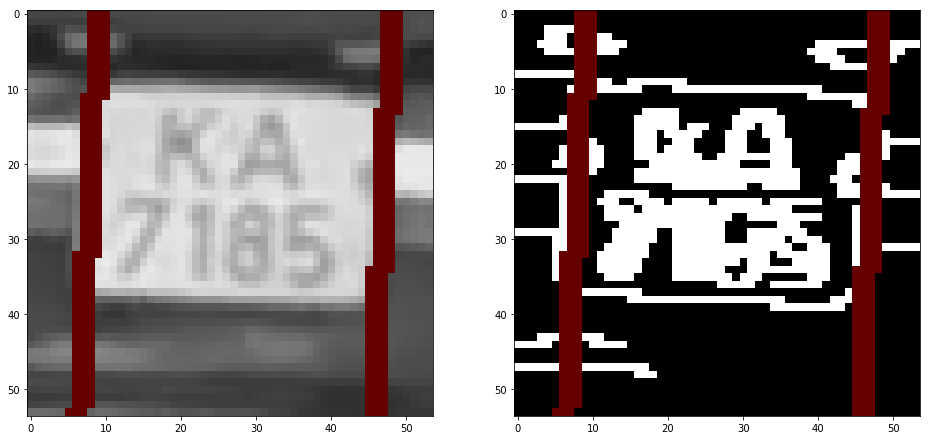

In [108]:
normalAngleHor = houghHor[0, 0, 1]
normalAngleVer = np.abs(normalAngleHor - 0.5 * np.pi)

houghVer = cv2.HoughLines(edgesVer, 1, np.pi/90, height//3, min_theta=0.7 * normalAngleVer, max_theta=1.3 * normalAngleVer)

img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
edges_copy = cv2.cvtColor(edgesVer, cv2.COLOR_GRAY2RGB)

for rho, theta in houghVer[:2, 0]:
    sin = np.sin(theta)
    cos = np.cos(theta)
    y0 = rho * sin
    x0 = rho * cos
    x1, y1 = (x0 + 1000 * sin, y0 -1000 * cos)
    x2, y2 = (x0 -1000 * sin, y0 + 1000 * cos)
    cv2.line(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (100, 0, 0), 2)
    cv2.line(edges_copy, (int(x1), int(y1)), (int(x2), int(y2)), (100, 0, 0), 2)

Fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img_copy)
ax2.imshow(edges_copy)